In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

2024-12-06 11:28:14.106481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733477294.129885   27273 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733477294.135915   27273 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:28:14.160749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset_url = "https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

In [4]:
data_dir = pathlib.Path(archive + "/Rice_Image_Dataset").with_suffix('')
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

75000


In [5]:
batch_size = 32
img_height = 75
img_width = 75

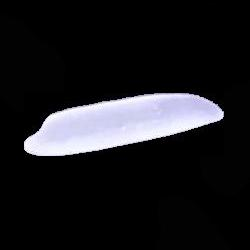

In [6]:
basmati = list(data_dir.glob('Basmati/*'))
PIL.Image.open(str(basmati[0]))

In [16]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.03,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

ds_test = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.03,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 75000 files belonging to 5 classes.
Using 15000 files for training.
Found 75000 files belonging to 5 classes.
Using 2250 files for validation.
Found 75000 files belonging to 5 classes.
Using 2250 files for validation.


2024-12-06 11:28:35.319215: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


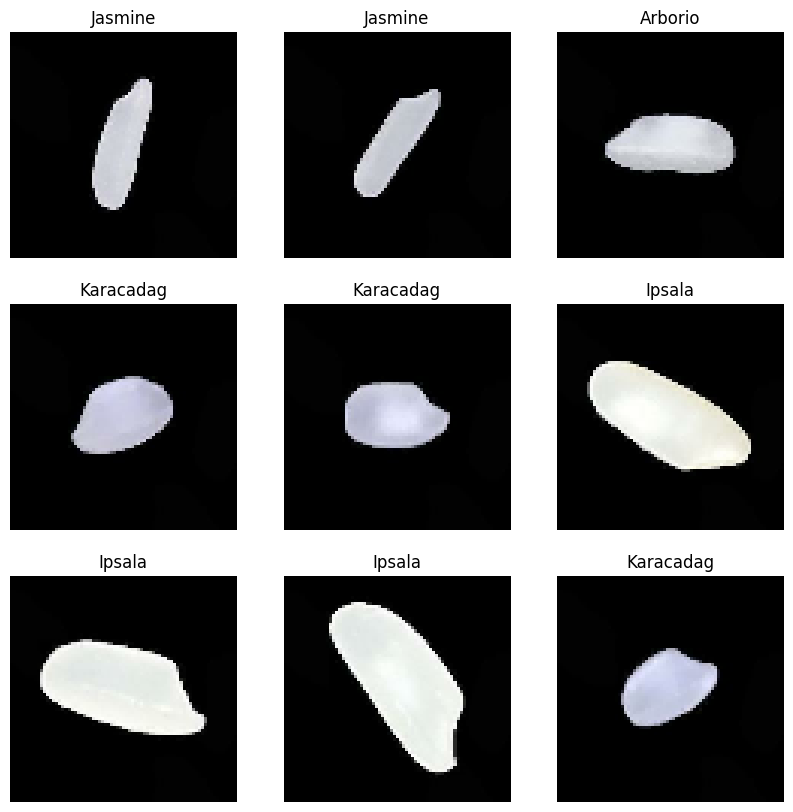

In [8]:
class_names = ds_train.class_names

num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 75, 75, 3)
(32,)


In [10]:
ds_train = ds_train.cache()
ds_val = ds_val.cache()

ds_train = ds_train.shuffle(buffer_size=1000)

## б) застосуйте перенесення навчання (transfer learning from pre-trained weights)

In [11]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False)

base_model.trainable = False

model = keras.Sequential([
	layers.Input(shape=(img_width, img_height, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation="sigmoid")
])

In [18]:
model.compile(
    optimizer='rmsprop',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    batch_size = batch_size,
	epochs = 20,
    validation_data = ds_val
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 137ms/step - accuracy: 0.9036 - loss: 0.4199 - val_accuracy: 0.8920 - val_loss: 0.2706
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9161 - loss: 0.2803 - val_accuracy: 0.9333 - val_loss: 0.2006
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 134ms/step - accuracy: 0.9273 - loss: 0.2534 - val_accuracy: 0.9560 - val_loss: 0.1643
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 129ms/step - accuracy: 0.9294 - loss: 0.2505 - val_accuracy: 0.9351 - val_loss: 0.2233
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - accuracy: 0.9322 - loss: 0.2338 - val_accuracy: 0.9662 - val_loss: 0.1126
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.9365 - loss: 0.2114 - val_accuracy: 0.9609 - val_loss: 0.1338
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 67s 142ms/step - accuracy: 0.9343 - loss: 0.2122 - val_accuracy: 0.9582 - val_loss: 0.1549
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 136ms/step - accuracy: 0.9380 - loss: 0

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

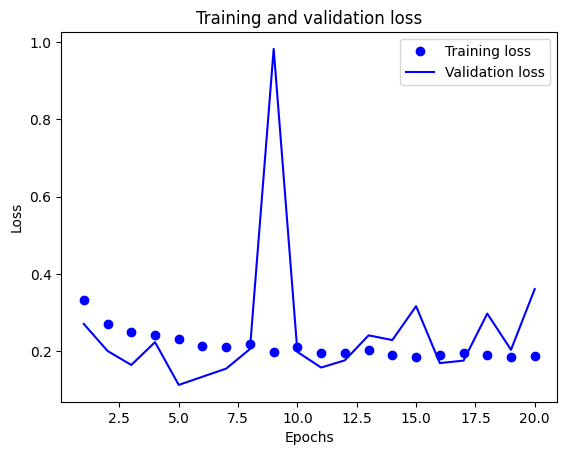

In [20]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
score = model.evaluate(ds_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.36080965399742126
Test accuracy: 0.9288889169692993


## Порівняйте результати

* Перенесене навчання виконується швидше.
* Навчена з нуля мережа показала кращі результати.

# 3. Рекурентні нейронні мережі
Вирішіть задачу класифікації текстів (з якими ви працювали в лабораторній № 2) за допомогою рекурентної нейромережі двома способами:
а) навчить мережу і embedding шар з нуля (from scratch)
б) використовуючи pretrained word embeddings
 Результати порівняйте між собою і з одержаними раніш. 
Приклади:
https://github.com/natsakh/Data-Analysis/tree/main/Pr_7
https://keras.io/examples/nlp/text_classification_from_scratch/
https://keras.io/examples/nlp/bidirectional_lstm_imdb/
https://keras.io/examples/nlp/pretrained_word_embeddings/
* у деяких прикладах, з наведених вище, вирішується задача класифікації текстів за допомогою згорткових мереж, але вони можуть бути використані як приклад препроцесінга